# FLAVA in TorchMultimodal

This notebook demonstrates how you can use FLAVA, a state-of-the-art multimodal understanding model in TorchMultimodal, on downstream tasks like zero-shot image classification and visual question answering. 

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://miro.medium.com/max/1400/1*fY1K44xECsC8sMv5nBOZAQ.webp", width=400, height=400)

FLAVA contains image and text encoders to generate unimodal embeddings that are fused through a multimodal encoder. It is trained on a combination of unimodal and multimodal tasks with losses for masked image modeling, masked text modeling, masked multimodal modeling, image-text matching, and a global contrastive loss. TorchMultimodal provides all of these components, along with pretrained weights and transforms so you can apply FLAVA to different tasks.

# Use FLAVA in TorchMultimodal for zero-shot image classification

In zero-shot image classification, a model aims to classify an image without having previously seen any labelled instances of the image's class.

To perform zero-shot image classification with FLAVA in TorchMultimodal, we import image and text transforms from TorchMultimodal, then load the FLAVA model with pretrained weights.

In [2]:
from torchmultimodal.transforms.flava_transform import FLAVAImageTransform
image_transform = FLAVAImageTransform(is_train=False)

/data/home/ebs/miniconda3/envs/flava-notebook/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torchmultimodal.transforms.bert_text_transform import BertTextTransform
text_transform = BertTextTransform()

100%|██████████████████████████████████████████████████████████████████████████████████| 232k/232k [00:00<00:00, 73.4MB/s]


In [4]:
from torchmultimodal.models.flava.model import flava_model
zero_shot_model = flava_model(pretrained=True)

After putting the model in eval mode, we perform zero-shot classification by passing an image and the label set through their respective encoders. We compute the similarity of the image embedding with each label embedding, then take the argmax for our predicted label.

In [5]:
import torch
from torch import nn

def predict(zero_shot_model, image, labels):
    zero_shot_model.eval()
    with torch.no_grad():
        image = image_transform(img)["image"].unsqueeze(0)
        texts = text_transform(labels)
        _, image_features = zero_shot_model.encode_image(image,projection=True)
        _, text_features = zero_shot_model.encode_text(texts, projection=True)
        scores= image_features @ text_features.t()
        probs = torch.nn.Softmax(dim=-1)(scores)
        label = labels[torch.argmax(probs)]
        print("Label probabilities :", {labels[i]: probs[:,i] for i in range(len(labels))})
        print(f"Predicted label: {label}")

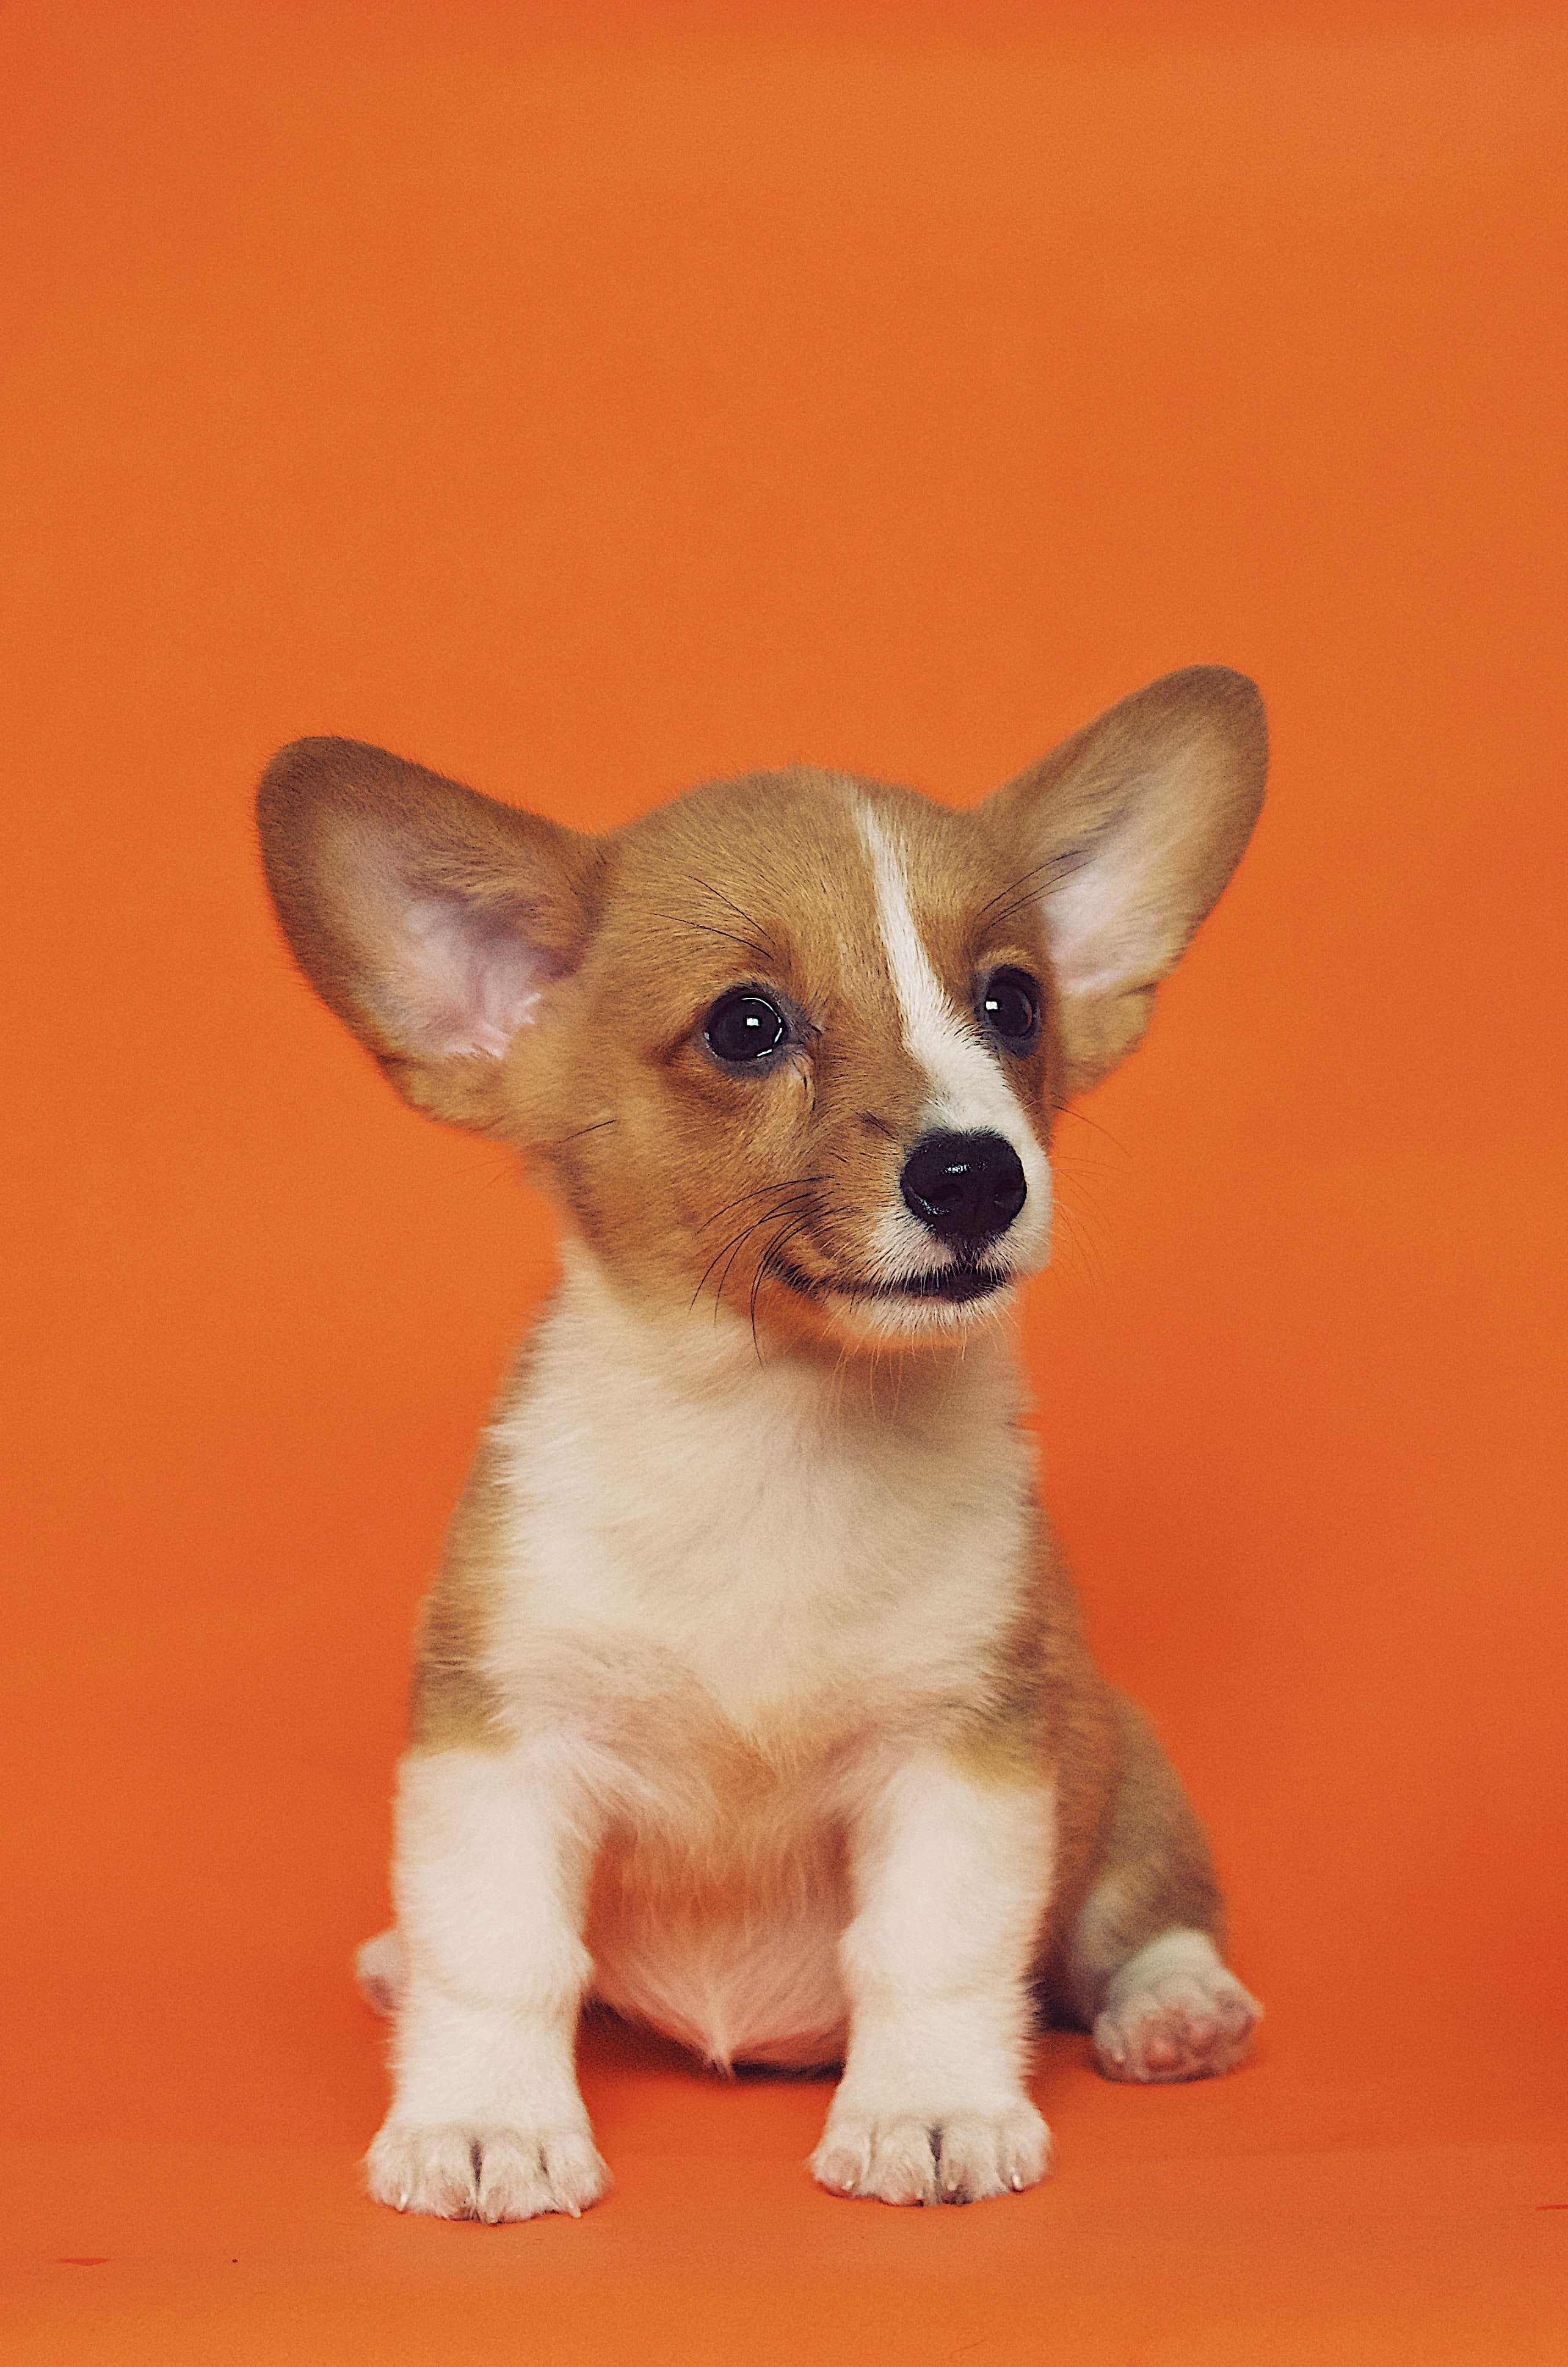

In [6]:
from PIL import Image
img = Image.open("small_dog.jpg")
from IPython.display import Image, display

display(Image('small_dog.jpg',width = 400, height = 400))

For zero-shot, we can define whatever label set we like. Here we pass dog, cat, and house, and the model correctly identifies the image as a dog.

In [7]:
predict(zero_shot_model, img, ["dog", "cat", "house"])

Label probabilities : {'dog': tensor([0.7169]), 'cat': tensor([0.1614]), 'house': tensor([0.1217])}
Predicted label: dog


Even if we get a bit more creative, we see that FLAVA can still pick out the correct label.

In [8]:
predict(zero_shot_model, img, ["cat pic", "photo of human", "picture of a pet"])

Label probabilities : {'cat pic': tensor([0.0600]), 'photo of human': tensor([0.1800]), 'picture of a pet': tensor([0.7600])}
Predicted label: picture of a pet


## Fine-tuning FLAVA in TorchMultimodal for visual question answering

In addition to zero-shot image classification, we can also apply FLAVA on visual question answering (VQA) tasks. In VQA tasks, we typically provide an image with a natural-language text prompt. See for instance the example below where we use MDETR, a multimodal object detector in TorchMultimodal, to perform visual question answering.

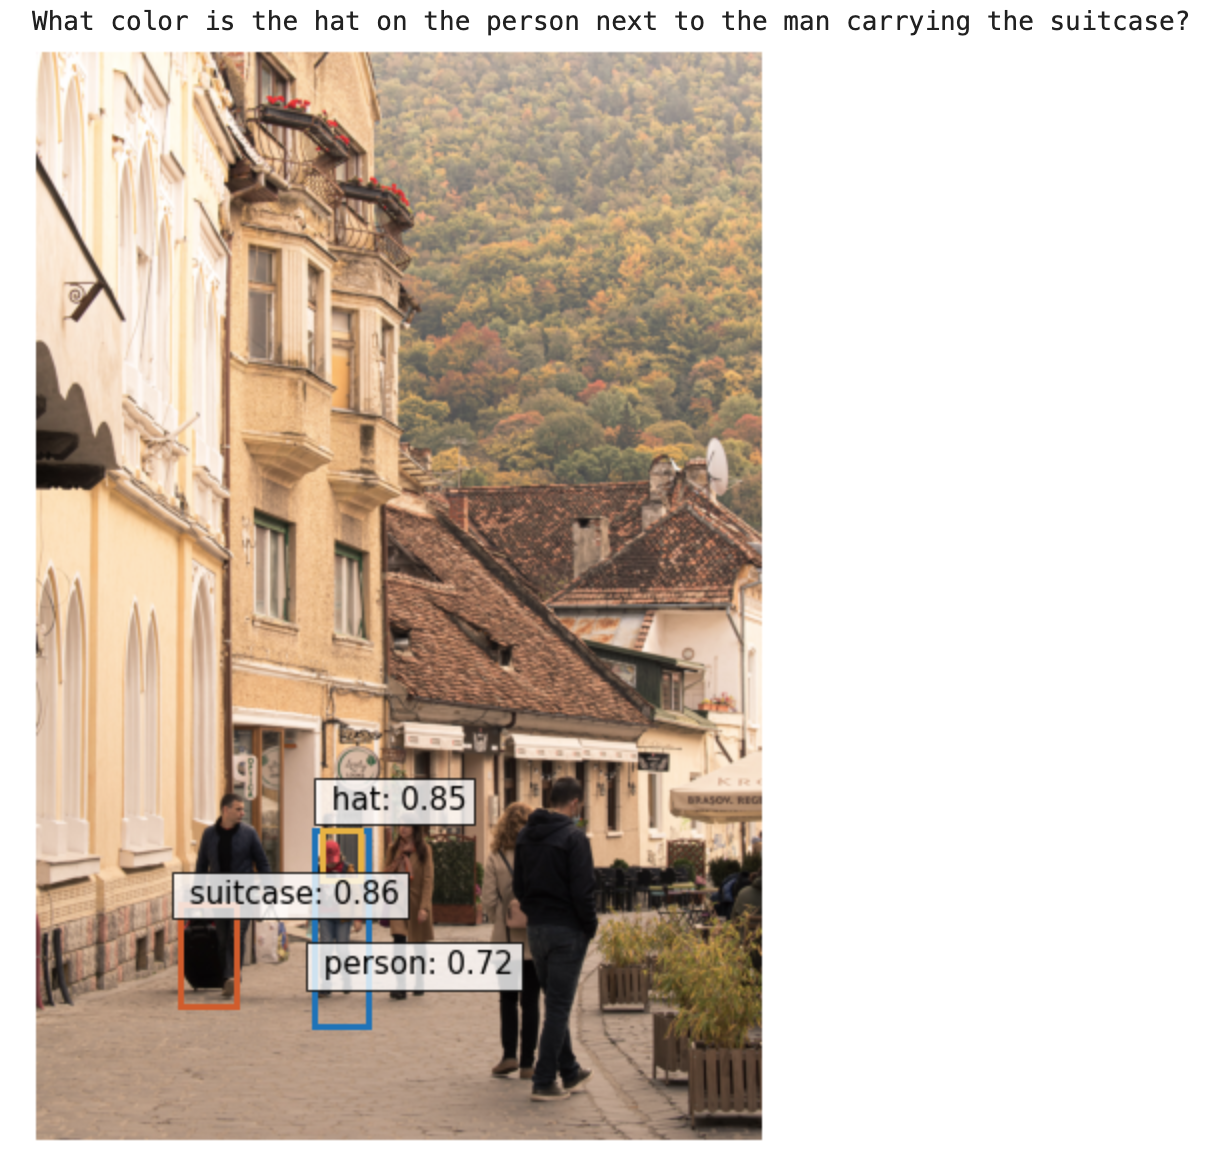

In [9]:
Image('vqa_example.jpg', width=600, height=900)

TorchMultimodal can also be used to fine-tune FLAVA for VQA tasks. For fine-tuning we can import the TextVQA dataset from the Hugging Face datasets library.

In [10]:
from datasets import load_dataset
dataset = load_dataset("textvqa")

No config specified, defaulting to: textvqa/textvqa
Found cached dataset textvqa (/data/home/ebs/.cache/huggingface/datasets/textvqa/textvqa/0.5.1/9b89037cc122c3b495b155a1bce4170851829843454e88f236bb8715d977c027)
100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 278.65it/s]


In [11]:
# Example question/answer pair from TextVQA dataset.
idx = 11
print("Question : ", dataset["train"][idx]["question"])
print("Answer : ",dataset["train"][idx]["answers"][0])

Question :  what airline is this plane for?
Answer :  airfrance


In [12]:
# Download the TextVQA answer vocab
!wget http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
!tar xf vocab.tar.gz

with open("vocabs/answers_textvqa_more_than_1.txt") as f:
    vocab = f.readlines()

answer_to_idx = {}
for idx, entry in enumerate(vocab):
    answer_to_idx[entry.strip("\n")] = idx

--2022-11-23 18:52:14--  http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 596389 (582K) [application/gzip]
Saving to: ‘vocab.tar.gz.1’

vocab.tar.gz.1      100%[===================>] 582.41K  1.34MB/s    in 0.4s    

2022-11-23 18:52:15 (1.34 MB/s) - ‘vocab.tar.gz.1’ saved [596389/596389]



Next we define a transform for our VQA dataset. As with zero-shot we can use existing transforms from TorchMultimodal, and we combine them with some extra logic for padding and fetching answer indices. 

In [13]:
import torch
from collections import defaultdict
from torchmultimodal.transforms.bert_text_transform import BertTextTransform
from functools import partial
from torch import nn
from torchmultimodal.transforms.flava_transform import FLAVAImageTransform

class VQATransform():
    def __init__(self, max_len=512):
        self.max_len = max_len
        self.text_transform = BertTextTransform()
        self.image_transform = FLAVAImageTransform()

    def __call__(self, input):
        transformed_sample = {}
        transformed_sample["image"] = [self.image_transform(input["image"][0].convert("RGB"))["image"]]

        tokenized=self.text_transform(input["question"])
        padded_token_ids = nn.functional.pad(tokenized, (0, self.max_len - tokenized.size(-1)), value=0)
        transformed_sample["text"] = padded_token_ids

        ans_to_count = defaultdict(int)
        for ans in input["answers"][0]:
            ans_to_count[ans] += 1
        max_value = max(ans_to_count, key=ans_to_count.get)
        ans_idx = answer_to_idx.get(max_value,0)
        transformed_sample["answers"] = torch.as_tensor([ans_idx])

        return transformed_sample


transform = VQATransform()
dataset.set_transform(transform)

100%|██████████████████████████████████████████████████████████████████████████████████| 232k/232k [00:00<00:00, 55.7MB/s]
Parameter 'transform'=<__main__.VQATransform object at 0x7f14965deb50> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In addition to the core FLAVA model used above for zero-shot, TorchMultimodal also provides implementations of models to be used on downstream tasks. In this case we can import a pretrained FLAVA model with a classifier head stacked on top for easy fine-tuning.

In [14]:
from torchmultimodal.models.flava.model import flava_model_for_classification
model = flava_model_for_classification(pretrained=True, num_classes=len(vocab))

Finally, we write a simple fine-tuning loop to fetch a few batches, pass through the model forward, then call backward and take a step with the optimizer. 

In [15]:
from torch import nn
BATCH_SIZE = 2
MAX_STEPS = 3
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset["train"], batch_size = BATCH_SIZE)
optimizer = torch.optim.AdamW(model.parameters())

epochs = 1
for _ in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        out = model(text = batch["text"], image = batch["image"], labels = batch["answers"])
        loss = out.loss
        loss.backward()
        optimizer.step()
        print(f"Loss at step {idx} = {loss}")
        if idx > MAX_STEPS-1:
            break

Loss at step 0 = 8.304468154907227
Loss at step 1 = 8.225822448730469
Loss at step 2 = 8.281700134277344
Loss at step 3 = 8.33006763458252


This is just a small-scale demonstration, but for a distributed setting you can also check out our blog [Scaling Multimodal Foundation Models in TorchMultimodal with PyTorch Distributed](https://pytorch.org/blog/scaling-multimodal-foundation-models-in-torchmultimodal-with-pytorch-distributed/?utm_source=twitter&utm_medium=organic_social&utm_campaign=evergreen).